# Accent classification with recurrent networks

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
#torch.multiprocessing.set_start_method("spawn")

In [2]:
# Restart from here
DEV = False
EPOCHS = 10

DEBUG = False
NUM_CONCAT = 20

In [3]:
True# autoreloads
%reload_ext autoreload
%autoreload 1
%aimport parameters

# Allows to load modules from parent directory
from time import time
import inspect, sys, os, json
from os.path import dirname, abspath
sys.path.append(dirname(dirname(abspath(inspect.getfile(inspect.currentframe())))))

from pathlib import Path
from os import makedirs

from tqdm import tqdm_notebook as tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from data.data_loader import create_binarizer, get_accents_counts
from utils import count_parameters
from models.modules import BatchRNN

from tensorboardX import SummaryWriter

import math

from torch.utils.data import DataLoader, Dataset

In [4]:
param = parameters.get_parameters(dev=DEV, epochs=EPOCHS, us_en=False)

## Utilities

In [5]:
def val_cnts(list_):
    return pd.Series(list_).value_counts()

def extract_num (s):
    return ''.join([c if c.isdigit() else '' for c in s])

def ids_list(manifest):
    ids = []
    with open(manifest) as f:
        for l in f:
            s = l.split('/')
            ids.append(f'{s[3]}-{s[5].split(".")[0]}')
    return ids

def make_accent_dict(manifest_path):
    accent_dict = {}
    class_dict = {}
    with open(manifest_path) as f:
        for l in f:
            wav, txt, acc = l.split(',')
            num = extract_num(wav)
            accent = acc.strip()
            if accent not in class_dict:
                new_key = 0 if (len(class_dict) == 0) else max(class_dict.values()) + 1
                class_dict[accent] = new_key
            accent_dict[num] = class_dict[accent]
    return accent_dict, {v: k for k, v in class_dict.items()}

## Data Loading

In [6]:
class KaldiDataset(Dataset):
    """Defines an iterator over the dataset. This class is intended to be used with PyTorch DataLoader"""
    
    def __init__(self, data_path, sample_ids, accent_id_dict):
        
        self.data_path = data_path
        self.accent_id_dict = accent_id_dict
        if isinstance(sample_ids, list):
            self._datafiles = sample_ids
        else:
            with open(sample_ids) as f:
                self._datafiles = [x.strip() for x in f.readlines()]
        
    def __getitem__(self, index):
             
        with open(os.path.join(self.data_path, self._datafiles[index])) as f:
            sample = json.load(f)
        
        target = self.accent_id_dict[extract_num(self._datafiles[index])]
        return torch.FloatTensor(sample), target
                      
    def __len__(self):
        
        return len(self._datafiles)

In [7]:
def collate_fn(batch_tot):
    """This function takes list of samples and assembles a batch. It is intended to used in PyTorch DataLoader."""
    res, tar = zip(*batch_tot)

    lens = torch.tensor([len(r) for r in res])
    tar = torch.tensor(tar)
    
    res = nn.utils.rnn.pad_sequence(res, batch_first=True)
    
    __, idx = lens.sort(descending=True)
    
    return res[idx], tar[idx], lens[idx]

class KaldiDataLoader(DataLoader):
    def __init__(self, *args, **kwargs):
        """
        Creates a data loader for SpeechDatasets.
        """
        super(KaldiDataLoader, self).__init__(*args, **kwargs)
        self.collate_fn = collate_fn

In [8]:
accent_id_dict, accent_dict = make_accent_dict(param['train_manifest'])

train_dataset = KaldiDataset(param['train_kaldi'], 
                              ids_list(param['train_manifest']), 
                              accent_id_dict)

train_loader = KaldiDataLoader(train_dataset, 
                                shuffle=True, 
                                num_workers=0,#param['num_worker'],
                                batch_size=param['batch_size'])

# for data in train_loader:
#     print(data[0])
#     print(data)
#     break

In [9]:
test_dict, __ = make_accent_dict(param['test_manifest'])

test_dataset = KaldiDataset(param['test_kaldi'], 
                              ids_list(param['test_manifest']), 
                              test_dict)

test_loader = KaldiDataLoader(test_dataset, 
                                shuffle=True, 
                                num_workers=param['num_worker'],
                                batch_size=param['batch_size'])

## Model definition

In [10]:
class AccentClassifier(nn.Module):
    def __init__(self,
                 input_size,
                 num_classes,
                 rnn_type,
                 hidden_size,
                 bn_size,
                 DEBUG = False,):
        
        super(AccentClassifier, self).__init__()
        
        self.hidden_size = hidden_size

        self._DEBUG = DEBUG
        
        self.rnn = rnn_type(input_size, hidden_size, 4, 
                            bidirectional=True, 
                            batch_first=True)

#         self.rnn = BatchRNN(input_size, 
#                             hidden_size,
#                             rnn_type=rnn_type,bidirectional=True,
#                             batch_norm=True)
        
        self.bn = nn.Sequential(
            nn.BatchNorm1d(hidden_size * 2),
            nn.Linear(hidden_size * 2, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, bn_size),
            nn.ReLU(),
        )
            
        self.fc = nn.Sequential(
            nn.BatchNorm1d(bn_size),
            nn.Linear(bn_size, num_classes),
            nn.ReLU(),
        )
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, lens):
        if self._DEBUG:
            print('input x', x.size())

        x = nn.utils.rnn.pack_padded_sequence(x, lens, batch_first=True)
        x, __ = self.rnn(x)
        x, lens = nn.utils.rnn.pad_packed_sequence(x, batch_first=True)
        
        if self._DEBUG:
            print('after rnn', x.size())
#        
#         x = x.view(x.size(0), x.size(1), 2, self.hidden_size)
        
#         if self._DEBUG:
#             print('after view', x.size())
            
        x = x.mean(dim=1)
        
        if self._DEBUG:
            print('after mean', x.size())
            
        x = self.bn(x)
        bn = x
        
        if self._DEBUG:
            print('after bn', x.size())

        x = self.fc(x)
        
        if self._DEBUG:
            print('after fc', x.size())
            
        x = self.softmax(x)
        
        if self._DEBUG:
            print('after softmax', x.size())
            
        self._DEBUG = False
        return x, bn

## Optimizer

In [11]:
model = AccentClassifier(input_size=train_dataset[0][0].size(1), 
                         num_classes=len(accent_dict),
                         rnn_type=param['rnn_type'],
                         hidden_size=param['rnn_hidden_size'],
                         bn_size=param['bn_size'],
                         DEBUG=DEBUG)

if param['cuda']:
    model.cuda()
    
from focalloss import FocalLoss
criterion = FocalLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=param['lr'][0])

print(model)
print('Model parameters counts:', count_parameters(model))

AccentClassifier(
  (rnn): GRU(40, 800, num_layers=4, batch_first=True, bidirectional=True)
  (bn): Sequential(
    (0): BatchNorm1d(1600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=1600, out_features=1024, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
  )
  (fc): Sequential(
    (0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=512, out_features=7, bias=True)
    (2): ReLU()
  )
  (softmax): Softmax()
)
Model parameters counts: 40804487


## Training

In [12]:
def train(epochs, 
          model, 
          train_loader, 
          test_loader, 
          optimizer, 
          criterion, 
          silent=True,
          exp_name='__tmp__'):

    # Tensorboard
    tb_path = Path(param['tensorboard_dir']) / exp_name
    makedirs(tb_path, exist_ok=True)
    tb_writer = SummaryWriter(tb_path)

    prev_epoch_val_loss = math.inf
    
    ## Train
    for epoch in range(1, param['epochs'] + 1):
        print(f'## EPOCH {epoch} ##')
        print(f'Training:')
        model.train()
        torch.cuda.empty_cache()
        # train
        epoch_losses = []
        for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
            inputs, target_accents, lens = data
            inputs = inputs.cuda()
            target_accents = target_accents.cuda()
            lens = lens.cuda()

            # Forward pass
            out, __ = model(inputs, lens)

            loss = criterion(out, target_accents)
            epoch_losses.append(loss.item())

            if not silent:
                print(f'Iteration {i+1}/{len(train_loader):<4}loss: {loss:0.3f}')

            # Gradient
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_loss = sum(epoch_losses) / len(train_loader)
        tb_writer.add_scalar('stats/train_loss', epoch_loss, epoch)
        print(f'Epoch {epoch} average loss: {epoch_loss:0.3f}')

        # validate
        print(f'Testing:')
        model.eval()
        acc = 0
        tot = 0
        with torch.no_grad():
            epoch_val_losses = []
            for data in tqdm(test_loader, total=len(test_loader)): ## ## 
                inputs, target_accents, lens = data
                inputs = inputs.cuda()
                target_accents = target_accents.cuda()

                out, __ = model(inputs, lens)

                val_loss = criterion(out, target_accents)
                epoch_val_losses.append(val_loss.item())

                out_arg = np.argmax(out, axis=1).cuda()
                diff = torch.eq(out_arg, target_accents)
                acc += torch.sum(diff)
                tot += len(target_accents)

            acc = acc.item() / tot * 100
            epoch_val_loss = sum(epoch_val_losses) / len(test_loader) ##

        tb_writer.add_scalar('stats/accuracy', acc, epoch)
        print(f'Accent classification accuracy: {acc:0.2f}%')

        tb_writer.add_scalar('stats/val_loss', epoch_val_loss, epoch)
        print(f'Average validation loss: {val_loss:0.3f}')

        if epoch_val_loss < prev_epoch_val_loss:
            print('New best model found.')
            torch.save(model.state_dict, f'saved/{exp_name}.pt')
            torch.save(model, f'saved/{exp_name}.pt')
            
    return model, prev_epoch_val_loss

In [13]:
SILENT = True
best_models = {}

from focalloss import FocalLoss
settings = {'rnn_type': [nn.GRU],
            'rnn_hidden_size': [800],
            'bn_size': [256],
            'criterion_gamma': [20, 3]}

for _rnn_type in settings['rnn_type']:
    for _rnn_hidden_size in settings['rnn_hidden_size']:
        for _criterion_gamma in settings['criterion_gamma']:
            for _bn_size in settings['bn_size']:
                exp_name = f'gamma-{_criterion_gamma}_ACC_CLASS_{type(_criterion_gamma)}_hidden-{_rnn_hidden_size}_bn-{_bn_size}'

                model = AccentClassifier(input_size=train_dataset[0][0].size(1), 
                                         num_classes=len(accent_dict),
                                         rnn_type=_rnn_type,
                                         hidden_size=_rnn_hidden_size,
                                         bn_size=_bn_size,
                                         DEBUG=DEBUG)

                if param['cuda']:
                    model.cuda()

                optimizer = torch.optim.Adam(model.parameters(), lr=param['lr'][0])

                print()
                print(f'{"":#<13}')
                print(exp_name)
                print(f'{"":#<13}')

                model, val_loss = train(param, 
                                        model,
                                        train_loader, 
                                        test_loader, optimizer, 
                                        FocalLoss(gamma=_criterion_gamma),
                                        silent=SILENT,
                                        exp_name=exp_name)



#############
gamma-20_ACC_CLASS_<class 'int'>_hidden-800_bn-256
#############
## EPOCH 1 ##
Training:


/home/thibault/code/deepspeech.pytorch/notebooks/focalloss.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)



Epoch 1 average loss: 0.059
Testing:



Accent classification accuracy: 55.99%
Average validation loss: 0.068
New best model found.


/home/thibault/anaconda3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type AccentClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## EPOCH 2 ##
Training:



Epoch 2 average loss: 0.042
Testing:



Accent classification accuracy: 61.40%
Average validation loss: 0.016
New best model found.
## EPOCH 3 ##
Training:



Epoch 3 average loss: 0.031
Testing:



Accent classification accuracy: 61.93%
Average validation loss: 0.048
New best model found.
## EPOCH 4 ##
Training:



Epoch 4 average loss: 0.022
Testing:



Accent classification accuracy: 59.01%
Average validation loss: 0.056
New best model found.
## EPOCH 5 ##
Training:



Epoch 5 average loss: 0.015
Testing:



Accent classification accuracy: 63.00%
Average validation loss: 0.067
New best model found.
## EPOCH 6 ##
Training:



Epoch 6 average loss: 0.011
Testing:



Accent classification accuracy: 59.45%
Average validation loss: 0.053
New best model found.
## EPOCH 7 ##
Training:



Epoch 7 average loss: 0.009
Testing:



Accent classification accuracy: 65.48%
Average validation loss: 0.048
New best model found.
## EPOCH 8 ##
Training:



Epoch 8 average loss: 0.007
Testing:



Accent classification accuracy: 62.11%
Average validation loss: 0.052
New best model found.
## EPOCH 9 ##
Training:



Epoch 9 average loss: 0.006
Testing:



Accent classification accuracy: 65.04%
Average validation loss: 0.059
New best model found.
## EPOCH 10 ##
Training:



Epoch 10 average loss: 0.005
Testing:



Accent classification accuracy: 64.77%
Average validation loss: 0.055
New best model found.

#############
gamma-3_ACC_CLASS_<class 'int'>_hidden-800_bn-256
#############
## EPOCH 1 ##
Training:



Epoch 1 average loss: 1.007
Testing:



Accent classification accuracy: 60.51%
Average validation loss: 0.877
New best model found.
## EPOCH 2 ##
Training:



Epoch 2 average loss: 0.927
Testing:



Accent classification accuracy: 57.14%
Average validation loss: 0.885
New best model found.
## EPOCH 3 ##
Training:



Epoch 3 average loss: 0.853
Testing:



Accent classification accuracy: 63.35%
Average validation loss: 0.763
New best model found.
## EPOCH 4 ##
Training:



Epoch 4 average loss: 0.785
Testing:



Accent classification accuracy: 62.64%
Average validation loss: 0.823
New best model found.
## EPOCH 5 ##
Training:


KeyboardInterrupt: 

## Tests

In [11]:

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2)
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black") #if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [12]:
model = torch.load("saved/gamma-20_ACC_CLASS_<class 'int'>_hidden-800_bn-256.pt")
accent_dict_ = accent_dict.copy()

In [21]:
# because we sorted differently during training
accent_dict_[2] = 'canada'
accent_dict_[3] = 'australia'

In [20]:
loader = test_loader
best_model = model
best_model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for data in tqdm(loader, total=len(loader)):
        inputs, target_accents, lens = data
        inputs = inputs.cuda()
        target_accents = target_accents.cuda()
        
        out, __ = best_model(inputs, lens)
        
        y_true.extend(target_accents)
        y_pred.append(np.argmax(out, axis=1))
        
    y_pred = torch.cat(y_pred)
            
    y_true_labels = [accent_dict[int(i)] for i in y_true]
    y_pred_labels = [accent_dict_[int(i)] for i in y_pred]

cnf_mat = confusion_matrix(y_true_labels, y_pred_labels, labels=list(accent_dict.values()))

/home/thibault/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().


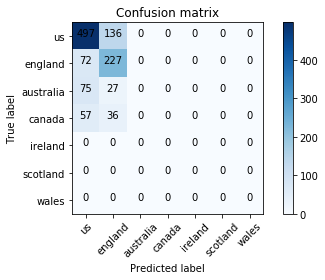

In [16]:
## GAMMA 0
plot_confusion_matrix(cnf_mat, classes=accent_dict.values(), normalize=False)

In [17]:
## GAMMA 0
from sklearn import metrics
print(metrics.classification_report(y_true_labels, y_pred_labels))

             precision    recall  f1-score   support

  australia       0.00      0.00      0.00       102
     canada       0.00      0.00      0.00        93
    england       0.53      0.76      0.63       299
         us       0.71      0.79      0.75       633

avg / total       0.54      0.64      0.58      1127



/home/thibault/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


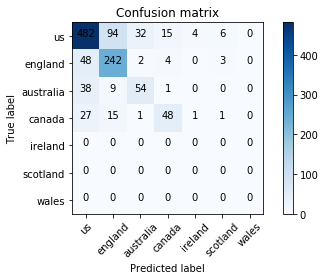

In [23]:
## GAMMA 20
plot_confusion_matrix(cnf_mat, classes=accent_dict.values(), normalize=False)

In [24]:
## GAMMA 20
#GAMMA 0
from sklearn import metrics
print(metrics.classification_report(y_true_labels, y_pred_labels))

             precision    recall  f1-score   support

  australia       0.61      0.53      0.57       102
     canada       0.71      0.52      0.60        93
    england       0.67      0.81      0.73       299
    ireland       0.00      0.00      0.00         0
   scotland       0.00      0.00      0.00         0
         us       0.81      0.76      0.79       633

avg / total       0.75      0.73      0.74      1127



/home/thibault/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


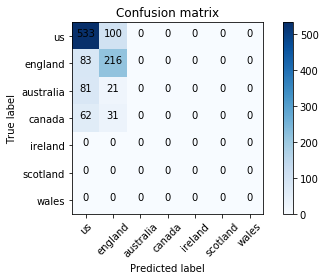

In [17]:
## GAMMA 0
plot_confusion_matrix(cnf_mat, classes=accent_dict.values(), normalize=False)

In [18]:
#GAMMA 0
from sklearn import metrics
print(metrics.classification_report(y_true_labels, y_pred_labels))

             precision    recall  f1-score   support

  australia       0.00      0.00      0.00       102
     canada       0.00      0.00      0.00        93
    england       0.59      0.72      0.65       299
         us       0.70      0.84      0.77       633

avg / total       0.55      0.66      0.60      1127



/home/thibault/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Clustering

In [22]:
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.manifold import TSNE

def plot_pca(X, y, _dict, projection='PCA', graph_title=''):
    if projection == 'PCA':
        Y = sklearnPCA(n_components=2).fit_transform(X)
    elif projection == 'TSNE':
        Y = TSNE(n_components=2).fit_transform(X)
    else:
        raise ValueError(f'Projection {projection} unkown.')

    plt.figure(figsize=(6, 4))
    for lab in _dict.values():
        plt.scatter(Y[y==lab, 0],
                    Y[y==lab, 1],
                    label=lab)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.title(f'{projection}: {graph_title}')
    plt.show()

/home/thibault/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().


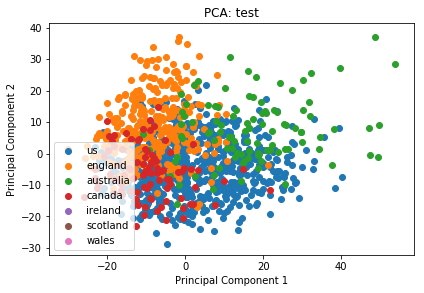

In [26]:
loader = test_loader
projection = 'PCA'
best_models = {}
best_models['test'] = (model, 12)

for model_name, (model, val_loss) in best_models.items():
    datapoints = []
    targets = []
    
    model.eval()
    with torch.no_grad():
        for data in tqdm(loader, total=len(loader)):
            
            inputs, target_accents, lens = data
            inputs = inputs.cuda()
            __, bn = best_model(inputs, lens)

            datapoints.append(bn)
            targets.append(target_accents)
            
    datapoints = torch.cat(datapoints)
    targets = torch.cat(targets)
    
    X = np.asarray(datapoints)
    y = np.asarray([accent_dict[t.item()] for t in targets])
    
    plot_pca(X, y, accent_dict, projection=projection, graph_title=model_name)

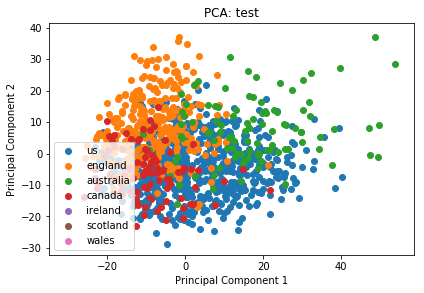

In [27]:
## GAMMA 20 PCA
plot_pca(X, y, accent_dict, projection=projection, graph_title=model_name)

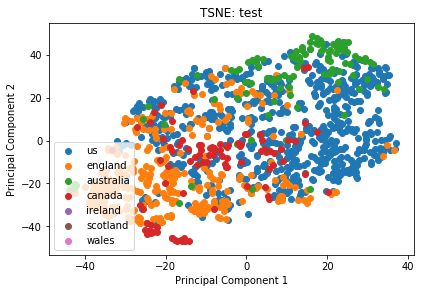

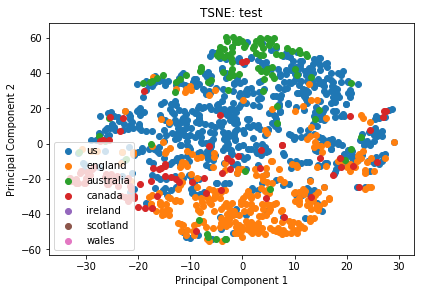

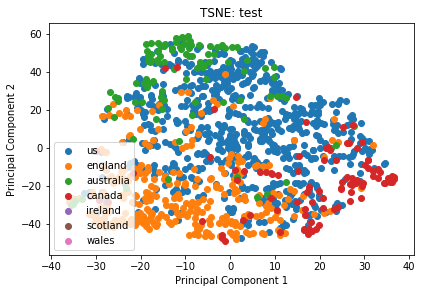

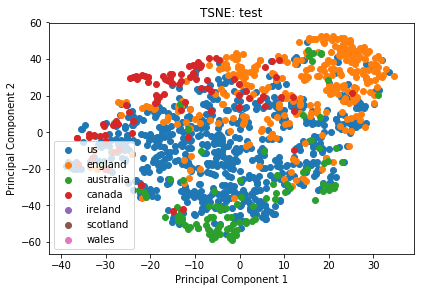

In [25]:
## GAMMA 20 TSNE
for __ in range(4):
    plot_pca(X, y, accent_dict, projection=projection, graph_title=model_name)

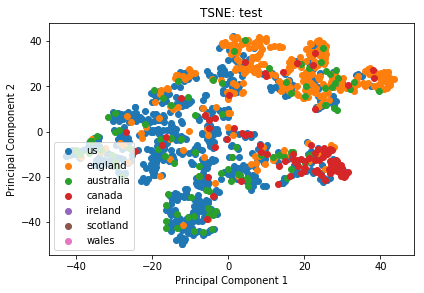

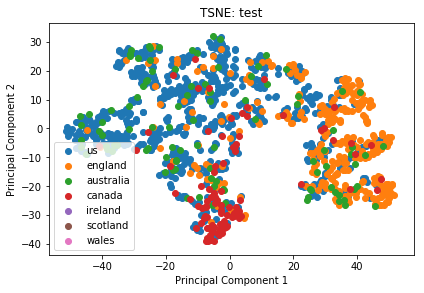

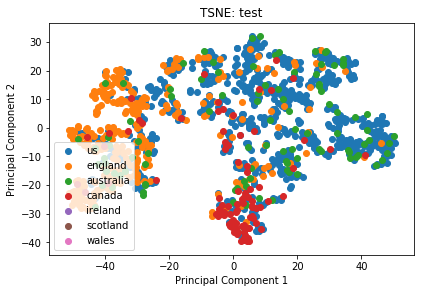

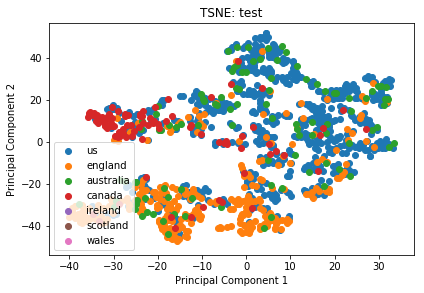

In [26]:
## GAMMA 0
for __ in range(4):
    plot_pca(X, y, accent_dict, projection=projection, graph_title=model_name)